In [1]:
import pandas as pd
import os

path = "/home/rupnik/macocu/task8/voxpopuli/hr/"
all_oggs =  []
for root, dirs, files in os.walk(path):
    for name in files:
        if name.endswith(".ogg"):
            all_oggs.append(name)



def has_diacritics(s):
    # import re
    # pattern = "[šđčćž]"
    # p = re.compile(pattern)
    # try:
    #     return p.search(s.lower()) is not None
    # except:
    #     return False
    return isinstance(s, str)
def assign_path(s):
    year = s[0:4]
    return os.path.join(
        path,
        year,
        s+".ogg"
    )

train = pd.read_csv("voxpopuli/hr/asr_train.tsv", sep="\t")
train["filename"] = train.id + ".ogg"
train["raw_has_diacritics"] = train.raw_text.apply(has_diacritics)
train["path"] = train.id.apply(assign_path)

test = pd.read_csv("voxpopuli/hr/asr_test.tsv", sep="\t")
test["filename"] = test.id + ".ogg"
test["raw_has_diacritics"] = test.raw_text.apply(has_diacritics)
test["path"] = test.id.apply(assign_path)

dev = pd.read_csv("voxpopuli/hr/asr_dev.tsv", sep="\t")
dev["filename"] = dev.id + ".ogg"
dev["raw_has_diacritics"] = dev.raw_text.apply(has_diacritics)
dev["path"] = dev.id.apply(assign_path)


train.head()

,id,raw_text,normalized_text,speaker_id,split,gender,is_gold_transcript,accent,filename,raw_has_diacritics,path
0,20181004-0900-PLENARY-hr_20181004-11:56:22_4,NaN,mislim kad bi se radilo o nekoj drugoj zemlji ...,119434,train,female,False,None,20181004-0900-PLENARY-hr_20181004-11:56:22_4.ogg,False,/home/rupnik/macocu/task8/voxpopuli/hr/2018/20...
1,20181004-0900-PLENARY-hr_20181004-11:56:22_5,NaN,pozdravljam rezoluciju i nadam se da e ona bar...,119434,train,female,False,None,20181004-0900-PLENARY-hr_20181004-11:56:22_5.ogg,False,/home/rupnik/macocu/task8/voxpopuli/hr/2018/20...
2,20131120-0900-PLENARY-3-hr_20131120-10:48:47_0,NaN,poljoprivreda je grana od iznimne vanosti za s...,119431,train,female,False,None,20131120-0900-PLENARY-3-hr_20131120-10:48:47_0...,False,/home/rupnik/macocu/task8/voxpopuli/hr/2013/20...
3,20131120-0900-PLENARY-3-hr_20131120-10:48:47_1,NaN,od dana pristupanja europskoj uniji tradiciona...,119431,train,female,False,None,20131120-0900-PLENARY-3-hr_20131120-10:48:47_1...,False,/home/rupnik/macocu/task8/voxpopuli/hr/2013/20...
4,20131120-0900-PLENARY-3-hr_20131120-10:48:47_2,naglasiti da hrvatska vina imaju dugu tradicij...,elim naglasiti da hrvatska vina imaju dugu tra...,119431,train,male,False,None,20131120-0900-PLENARY-3-hr_20131120-10:48:47_2...,True,/home/rupnik/macocu/task8/voxpopuli/hr/2013/20...


In [2]:
train.shape[0], dev.shape[0], test.shape[0]

(10987, 1285, 666)

In [3]:
all(train.filename.isin(all_oggs)), all(test.filename.isin(all_oggs)), all(dev.filename.isin(all_oggs))

(True, True, True)

All instances have the files present. How many of the instances do not have raw_text?:

In [4]:
train.dropna().shape[0],dev.dropna().shape[0], test.dropna().shape[0]

(5803, 789, 334)

And even stricter: how many instances satisfy the diacritics test on raw text?

In [5]:
train[train.raw_has_diacritics].shape[0], dev[dev.raw_has_diacritics].shape[0], test[test.raw_has_diacritics].shape[0]

(5803, 789, 334)

In [6]:

from pydub import AudioSegment

audio = AudioSegment.from_ogg(train.path[0])
len(audio)/1000
def get_duration_and_convert(path):
    from pydub import AudioSegment
    aseg = AudioSegment.from_ogg(path)
    aseg.export(path.replace(".ogg", ".wav"), format="wav", parameters = "-ac 1 -ar 16000".split())
    return len(aseg)/1000
def get_durations(series):
    from concurrent.futures import ProcessPoolExecutor
    with ProcessPoolExecutor(max_workers=60) as executor:
        results = list(executor.map(get_duration_and_convert, series))
    return results

train["duration"] = get_durations(train.path)
dev["duration"] = get_durations(dev.path)
test["duration"] = get_durations(test.path)

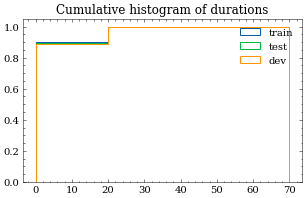

In [7]:
import matplotlib.pyplot as plt
plt.style.use("science,no-latex".split(","))
plt.figure(figsize=(5,3))
plt.hist(train.duration, bins=[0, 20, 70], density=True, label="train", histtype="step", cumulative=True)
plt.hist(test.duration, bins=[0, 20, 70], density=True, label="test", histtype="step", cumulative=True)
plt.hist(dev.duration, bins=[0, 20, 70], density=True, label="dev", histtype="step", cumulative=True)
plt.legend()
plt.title("Cumulative histogram of durations")
plt.savefig("images/27_cumulative_hist_of_durations.png")
plt.show()


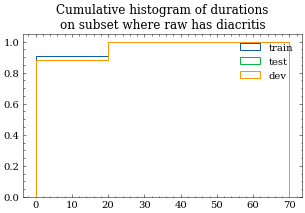

In [8]:
import matplotlib.pyplot as plt
plt.style.use("science,no-latex".split(","))
plt.figure(figsize=(5,3))
plt.hist(train.duration[train.raw_has_diacritics], bins=[0, 20, 70], density=True, label="train", histtype="step", cumulative=True)
plt.hist(test.duration[test.raw_has_diacritics], bins=[0, 20, 70], density=True, label="test", histtype="step", cumulative=True)
plt.hist(dev.duration[dev.raw_has_diacritics], bins=[0, 20, 70], density=True, label="dev", histtype="step", cumulative=True)
plt.legend()
plt.title("Cumulative histogram of durations\non subset where raw has diacritis")
plt.savefig("images/27_cumulative_hist_of_durations_where_raw_has_diacritics.png")
plt.show()

In [9]:
duration = train.duration.sum()+test.duration.sum()+dev.duration.sum()
duration/3600

41.31133777777779

In [10]:
for df in [train, dev, test]:
    df["wavpath"] = df.path.str.replace(".ogg", ".wav")

/tmp/ipykernel_600995/3012997713.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["wavpath"] = df.path.str.replace(".ogg", ".wav")


In [11]:
duration = train[train.raw_has_diacritics].duration.sum()+test[test.raw_has_diacritics].duration.sum()+dev[dev.raw_has_diacritics].duration.sum()
duration/3600

21.54295111111111

In [12]:
train.head(4)

,id,raw_text,normalized_text,speaker_id,split,gender,is_gold_transcript,accent,filename,raw_has_diacritics,path,duration,wavpath
0,20181004-0900-PLENARY-hr_20181004-11:56:22_4,NaN,mislim kad bi se radilo o nekoj drugoj zemlji ...,119434,train,female,False,None,20181004-0900-PLENARY-hr_20181004-11:56:22_4.ogg,False,/home/rupnik/macocu/task8/voxpopuli/hr/2018/20...,19.984,/home/rupnik/macocu/task8/voxpopuli/hr/2018/20...
1,20181004-0900-PLENARY-hr_20181004-11:56:22_5,NaN,pozdravljam rezoluciju i nadam se da e ona bar...,119434,train,female,False,None,20181004-0900-PLENARY-hr_20181004-11:56:22_5.ogg,False,/home/rupnik/macocu/task8/voxpopuli/hr/2018/20...,6.520,/home/rupnik/macocu/task8/voxpopuli/hr/2018/20...
2,20131120-0900-PLENARY-3-hr_20131120-10:48:47_0,NaN,poljoprivreda je grana od iznimne vanosti za s...,119431,train,female,False,None,20131120-0900-PLENARY-3-hr_20131120-10:48:47_0...,False,/home/rupnik/macocu/task8/voxpopuli/hr/2013/20...,4.760,/home/rupnik/macocu/task8/voxpopuli/hr/2013/20...
3,20131120-0900-PLENARY-3-hr_20131120-10:48:47_1,NaN,od dana pristupanja europskoj uniji tradiciona...,119431,train,female,False,None,20131120-0900-PLENARY-3-hr_20131120-10:48:47_1...,False,/home/rupnik/macocu/task8/voxpopuli/hr/2013/20...,7.800,/home/rupnik/macocu/task8/voxpopuli/hr/2013/20...


In [13]:
tr = set(train[train.raw_has_diacritics].speaker_id.unique())
de = set(dev[dev.raw_has_diacritics].speaker_id.unique())
te = set(test[test.raw_has_diacritics].speaker_id.unique())

In [14]:
tr.intersection(de), tr.intersection(te)

(set(),
 {'112744',
  '112748',
  '112753',
  '112755',
  '112760',
  '119431',
  '119434',
  '119435',
  '119436',
  '119439',
  '124749',
  '124754',
  '124756',
  '185341',
  'None'})

In [15]:
os.mkdir("vox_populi_dev")
def copydev(path):
    basename = os.path.basename(path)
    os.system(f"cp {path} vox_populi_dev/{basename}")


os.mkdir("vox_populi_test")
def copytest(path):
    basename = os.path.basename(path)
    os.system(f"cp {path} vox_populi_test/{basename}")


from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor(max_workers=60) as executor:
    executor.map(copydev, dev[dev.raw_has_diacritics].wavpath.values.tolist())
    executor.map(copytest, test[test.raw_has_diacritics].wavpath.values.tolist())




In [ ]:
dev[dev.raw_has_diacritics].to_csv("vox_populi_dev.csv", index=False)
test[test.raw_has_diacritics].to_csv("vox_populi_test.csv", index=False)